In [2]:
import numpy as np
import sequence_jacobian as sj
from scipy import linalg
from scipy import optimize
import matplotlib.pyplot as plt
import pandas as pd
import json

# household.py

In [3]:
# import productivity transition matrix, normalize
Pi_e = linalg.expm(np.loadtxt('inputs/kmv_process/ymarkov_combined.txt'))
Pi_e /= np.sum(Pi_e, axis=1)[:, np.newaxis]

# productivity stationary matrix
pi_e = sj.utilities.discretize.stationary(Pi_e)

# Grid of all possible productivity states
e_grid_short = np.exp(np.loadtxt('inputs/kmv_process/ygrid_combined.txt'))
e_grid_short /= e_grid_short @ pi_e
n_e = len(pi_e) 

In [4]:
# Given probabilities and beta high and low,
# return a matrix with a grid of both beta values
# the transition matrix for beta states
# and a grid with the probability to draw each beta

def make_betas(beta_hi, dbeta, omega, q):
    """Return beta grid [beta_hi-dbeta, beta_high] and transition matrix,
    where q is probability of getting new random draw from [1-omega, omega]"""
    # q = prob of drawing new b
    # omega = prob of getting beta high
    beta_lo = beta_hi - dbeta
    # beta high = patient; beta low = impatient; dbeta = difference
    b_grid = np.array([beta_lo, beta_hi]) # 1D-array with two elements with each beta value
    pi_b = np.array([1 - omega, omega])
    #2-value array with probability of bhigh, blow if a random draw is needed
    Pi_b = (1-q)*np.eye(2) + q*np.outer(np.ones(2), pi_b)
    return b_grid, Pi_b, pi_b

In [5]:
# make grid for assets and a stationary distrib for all beta-e states

def make_grids(min_a, max_a, n_a, beta_hi, dbeta, omega, q):
    ### asset and beta grids
    a_grid = sj.grids.asset_grid(min_a, max_a, n_a) # creates a grid for assets 
    #(tightly spaced for low values, the contrary for high values, as is common in HA models)

    b_grid_short, Pi_b, pi_b = make_betas(beta_hi, dbeta, omega, q) 
    # calls the make_betas fct to get the grid of two beta values, 
    # probability of switching and transition matrix for beta

    ### combine grids for beta and e (latter pre-loaded from KMV above)
    e_grid = np.kron(np.ones_like(b_grid_short), e_grid_short)
     # repeats e_grid_short for each b state
    beta = np.kron(b_grid_short, np.ones_like(e_grid_short))
    # repeats b_grid_short for each e state
    
    Pi = np.kron(Pi_b, Pi_e) 
    # Pi_b is the transition matrix for the beta states 
    # Pi_e is the transition matrix for the income states
    #combine transition matrices for joint beta and e states

    pi_pdf = np.kron(pi_b, pi_e)
    # pi_b the stationary distribution for b-types
    # pi_e the stationary distribution for e_types
    # combined mass of agents in equilibrium for each joint value of beta and e
    return e_grid, Pi, a_grid, beta, pi_pdf

In [6]:
# returns EARNINGS (before being affected by any beta)
def income(wN_aftertax, N, e_grid, Tr_lumpsum, Tax_richest, zeta, pi_pdf):
        # after tax income, total L supply, all possible states of prod grid, lumpsum transfer, 
        # tax for the richest, cyclicality parameter (MP exercise page 17), stationary distrib 
        # over (share of agents in each) prod states

    # Auclert-Rognlie 2020 incidence function for labor income, with cyclicality parameter zeta
    # in default case with zeta = 0, this is just gamma / N = 1 and irrelevant   
    gamma_N = e_grid ** (zeta * np.log(N)) / np.vdot(
        e_grid ** (zeta * np.log(N)), pi_pdf
    ) 

    # net after-tax income (include lump-sum transfer option)
    y = wN_aftertax * e_grid * gamma_N + Tr_lumpsum

    # also add option to tax richest type at margin
    y = y.reshape(-1, n_e)  # reshape to beta*e grid
    y[:, -1] -= Tax_richest / pi_e[-1].sum()  # tax richest e type
    y = y.ravel()  # flatten back
    return y

# Other possibility for changing the previous fct:
def earnings(wN_aftertax, N, e_grid, Tr_lumpsum, Tax_richest):
    # net after-tax income (include lump-sum transfer option)
    y = wN_aftertax * e_grid + Tr_lumpsum

    # also add option to tax richest type at margin
    y = y.reshape(-1, n_e)  # reshape to beta*e grid
    y[:, -1] -= Tax_richest / pi_e[-1].sum()  # tax richest e type
    y = y.ravel()  # flatten back
    return y

In [7]:
# HA HH BLOCK
# Define exogenous vars, policy, backward iteration method parameters for HA
@sj.het(
    exogenous="Pi", policy="a", backward="Va", backward_init=sj.hetblocks.hh_sim.hh_init
)

# Define the HA HH block with space for beta vector
# returns a, c, Va
def hh_raw(Va_p, a_grid, y, r, beta, eis):
    """Household block. Slightly modify sequence_jacobian.hetblocks.hh_sim.hh to allow for beta vector"""
    # future marginal utility
    uc_nextgrid = (
        beta[:, np.newaxis] * Va_p
    )  # reshape the 1D beta array into a column vector
    # each row of the Va_p is multiplied by the corresponding beta 
    # originally in the hh fct: uc_nextgrid = beta * Va_p

    # future consumption
    c_nextgrid = uc_nextgrid ** (-eis)
    # derive the nex period consumption (c') frim the marginal utility (u'c) assuming that uc= c^(-1/eis)
    # negative because invserse relationship between marginal utility and consumption

    coh = (1 + r) * a_grid[np.newaxis, :] + y[:, np.newaxis] 
    # a_grid[np.newaxis, :] = reshape a_grid into a row vector
    # y[:, np.newaxis] = reshapes y into a column vector 
    a = sj.interpolate.interpolate_y(c_nextgrid + a_grid, coh, a_grid)
    # c_nextgrid + a_grid = add asset levels to the consumption of the next period consumption -> total ressource needs
    # sj.interpolate.interpolate_y (see below) 
    sj.misc.setmin(a, a_grid[0])
    # ensures that savings (a) do not fall below 0
    c = coh - a 
    Va = (1 + r) * c ** (-1 / eis) # upadtes marginal value of assets for the current period
    return Va, a, c

In [8]:
def group_c_not_agg(c:np.ndarray, D:np.ndarray):
    consumption = c

    # 1. find the last element's row and column
    # 2. find the rest of the mass of peope included in that element to reach our %
    # 3. find what share of the mass of people in the cell rest represents 
    # 4. create share matrix and multiply by c

    if D.shape != consumption.shape:
        raise Exception("Both distributions do not have the same size.")
    

    def get_percent_of_half_matrix(half_D: np.ndarray, percentage: float) -> np.ndarray:
        inclusion_matrix = np.zeros_like(half_D)

        cumulative_share = 0
        for row in range(half_D.shape[0]):
            for col in range(half_D.shape[1]):
                cumulative_share += half_D[row, col]
                inclusion_matrix[row, col] = 1

                if cumulative_share > percentage: # we are in the rest cell
                    rest_share = (percentage - cumulative_share) / half_D[row, col] # share of the rest
                    inclusion_matrix[row, col] = rest_share # overwrite previous 1 with share of rest
                    return inclusion_matrix
                
                elif cumulative_share == percentage: # landed exactly on the percentage
                    return inclusion_matrix

    def get_percent_of_full_matrix(full_D: np.ndarray, percentage: float, start_bottom_right=False):
        # split in half
        if start_bottom_right:
            percentage = 1 - percentage

        half_percentage = percentage / 2
        half_height = full_D.shape[0] // 2

        beta_high = full_D[:half_height,:]
        beta_low = full_D[half_height:,:]

        # get 0/1s matrix from half functions
        beta_high_inclusion = get_percent_of_half_matrix(beta_high, half_percentage)
        beta_low_inclusion = get_percent_of_half_matrix(beta_low, half_percentage)

        # if necessary subtract from 1
        if start_bottom_right:
            beta_high_inclusion = 1 - beta_high_inclusion
            beta_low_inclusion = 1 - beta_low_inclusion

        # merge them back together
        return np.vstack([beta_high_inclusion, beta_low_inclusion])


    t10 = get_percent_of_full_matrix(D, 0.1, start_bottom_right=True)
    b10 = get_percent_of_full_matrix(D, 0.1, start_bottom_right=False)
    t50 = get_percent_of_full_matrix(D, 0.5, start_bottom_right=True)
    b50 = get_percent_of_full_matrix(D, 0.5, start_bottom_right=False)

    c_t10 = consumption * t10
    c_b10 = consumption * b10
    c_t50 = consumption * t50
    c_b50 = consumption * b50

    return c_t10, c_b10, c_t50, c_b50            

In [9]:
# add grid and income functions to the hh block so that it works all together
hh_ha = hh_raw.add_hetinputs([make_grids, income]) 
hh_ha = hh_ha.add_hetoutputs([group_c_not_agg])
hh_ha.name = "hh_ha"

In [10]:
# TA HH BLOCK
# Define the unknowns for TA
@sj.solved(unknowns={"C_RA": 1, "A": 1}, targets=["euler", "budget_constraint"])

# Define the TA HH block (with space for beta vector?)
# returns euler, BC, C constrained, C unconstrained
def hh_ta(C_RA, A, wN_aftertax, eis, beta, r, lam):
    euler = (beta * (1 + r(+1))) ** (-eis) * C_RA(+1) - C_RA  
    # Euler eq for consumption of infinitely lived, unconstrained H2M hhs
        #(why -C_RA and not - (-eis) * C_RA(+1))??? Shouldn't it be the derivative?

    C_H2M = wN_aftertax  # consumption of constrained H2M household
    C = (1 - lam) * C_RA + lam * C_H2M # aggregate consumption (weighted average for both hhs)
    
    budget_constraint = (
        (1 + r) * A(-1) + wN_aftertax - C - A # buget constraint. R-E = 0
    )  # budget constraint for infinitely lived household
    return euler, budget_constraint, C_H2M, C

In [11]:
# RA HH BLOCK
# Define the unknowns for RA
@sj.solved(unknowns={"C": 1, "A": 1}, targets=["euler", "budget_constraint"])

# Define the RA HH block (with space for beta vector?)
# returns euler, BC
def hh_ra(C, A, wN_aftertax, eis, beta, r):
    euler = (beta * (1 + r(+1))) ** (-eis) * C(+1) - C # same euler equation
    budget_constraint = (1 + r) * A(-1) + wN_aftertax - C - A # same budget constraint
    return euler, budget_constraint

In [12]:
# CALIBRATION
# insert calibration of info needed for a, b and e grids,
# N and earnings info,
# tax richest and lumpsum transfer are here too (but =0)
calibration_ha = dict(
    eis=1, # elasticity of intemporal substitution (how consumption changes with interest rates)
    min_a=0,
    max_a=4000,
    n_a=200,
    r=0.005, #int rate
    q=0.01, # prob of new beta draw
    Tr_lumpsum=0, # lump-sum transfers from the government to the households
    Tax_richest=0, # tax on the richest households 
    zeta=0,
)
calibration_ha["N"], calibration_ha["wN_aftertax"] = 1, 0.7

# Annual Review Main 


In [13]:
# import HA hh blocks ONLY ? from household.py
from household import (hh_ha as hh,
                       calibration_ha as calibration)

### Blocks

In [14]:
# Firm's block
# Returns N, wN, div
@sj.simple
def production(Y, mu):
    """Split aggregate income into pre-tax wage and dividends income"""
    N = Y   
    wN = Y / mu            
    div = Y - wN    
    return N, wN, div

In [15]:
# Govt bond block
# Returns r, price of bonds
@sj.simple
def real_ST_bonds(r_ante):
    """Bond returns if bonds are short term and real (our default assumption)"""
    r_post_bonds = r_ante(-1)
    qbond = 1/(1 + r_ante)
    return r_post_bonds, qbond

In [16]:
# Govt Fiscal decisions block
# Returns T, t, T residuals, wN and div after tax
@sj.simple
def fiscal(B, r_post_bonds, G, Y, wN, div, tax_rate_shock, T_shock, T_rule_coeff, qbond):
    """Calculate taxes and after-tax wage and dividend income"""
    T = (1 + r_post_bonds) * B(-1) + G - B  # total tax burden consistent with B and G
    tax_rate = T / Y                        # required tax rate
    wN_aftertax = (1 - tax_rate) * wN       # after-tax wage income
    div_aftertax = (1 - tax_rate) * div     # after-tax dividends

    # ALW (2024) rule
    tax_rate_res = tax_rate - tax_rate.ss - tax_rate_shock
    
    # Tax revenue rule (used for FTPL and alternative fiscal rule)
    T_res = T - T.ss - T_rule_coeff * (B(-1) - B.ss) - T_shock
    
    # Default fiscal rule for monetary policy: constant amount owed tomorrow
    constant_owed_res = B/qbond - B.ss/qbond.ss
    return T, tax_rate, wN_aftertax, div_aftertax, tax_rate_res, T_res, constant_owed_res

In [17]:
# EXTENSION 
# #tax to the richest block
# Returns T, t, wN and div after tax, tax on the richest
@sj.simple
def fiscal_richest(B, r_post_bonds, G, Y, wN, div):
    """Variant of above where any taxes beyond steady state are raised only on the richest"""
    Tax_total = (1 + r_post_bonds) * B(-1) + G - B  
    T = Tax_total.ss                                
    Tax_richest = Tax_total - T                     
    tax_rate = T / Y
    wN_aftertax = (1 - tax_rate) * wN
    div_aftertax = (1 - tax_rate) * div
    return T, tax_rate, wN_aftertax, div_aftertax, Tax_richest

In [18]:
# value and div condition block
@sj.solved(unknowns={'p': (0.001,50)}, targets=['cap_cond']) 
def capitalization(div_aftertax, r_ante, p):
    """Calculate end-of-period value p of firm and ex-post return on equity holdings"""
    cap_cond = p - (div_aftertax(+1) + p(+1))/(1 + r_ante)
    r_post_equity = (div_aftertax + p)/p(-1) - 1
    return r_post_equity, cap_cond

In [19]:
# int rate and debt condition block
@sj.simple
def ex_post_r(r_post_equity, r_post_bonds, B, p):
    """Calculate ex-post return on all assets, combining equity and bond returns"""
    r = (p(-1) * r_post_equity + B(-1) * r_post_bonds) / (p(-1) + B(-1))
    return r

In [20]:
# NK PC block
# returns residuals
@sj.simple
def nkpc(pi, kappa, N, Y, G, beta_ave, vscale, frisch, tax_rate, mu, eis):
    """New Keynesian Phillips Curve"""
    wedge = vscale*N**(1/frisch) - (1-tax_rate) / mu * (Y-G)**(-1/eis) # using C = Y-G
    nkpc_res = kappa * wedge + beta_ave * pi(+1) - pi
    return nkpc_res

In [21]:
# EXTENSION 
# Taylor rule block
@sj.simple
def taylor_rule(rstar, pi, phi):
    """Taylor rule for monetary policy"""
    i = rstar + phi * pi
    r_ante = i - pi(+1)
    return r_ante

In [22]:
# asset and goods MC condition block
@sj.simple
def mkt_clearing(A, Y, C, p, B, G):
    """Market clearing conditions"""
    asset_mkt = A - p - B
    goods_mkt = C + G - Y
    return asset_mkt, goods_mkt

### Assembling the model

In [23]:
# ASSEMBLING THE BLOCKS

#  create a model for each agent variation 
# combining common blocks and specific hh blocks
common_blocks = [production, real_ST_bonds, fiscal, capitalization, ex_post_r, nkpc, mkt_clearing]
models_hh = [hh_ha, hh_ta, hh_ra]
model_names = ['ha', 'ta', 'ra']
models = {name: sj.combine(common_blocks + [hh]) for hh, name in zip(models_hh, model_names)}

### Calibration

In [24]:
# AGGREGATES' values
Y = 1           # normalization
r = 0.005       # 2% annual real interest rate
A = 20          # 500% assets to annual GDP
B = 4           # 100% debt to annual GDP
G = 0.2         # 20% gov spending 
C = Y - G       # remaining 80% is consumption

# parameter fcts not defined in the blocks
tax = G + r*B                   # implied steady-state tax rate
j = A - B                       # firm equity to GDP
div_post = r * j                # implied post-tax dividends to justify firm equity
div = div_post / (1 - tax)      # implied pre-tax dividends
w_post = (1 - tax) * (1 - div)  # implied post-tax wage
mu = 1 / (1 - div)              # implied markup
mu

# Parameters of utilities
eis = 1                                      # elasticity of intertemporal substitution
frisch = 1                                   # Frisch elasticity of labor supply (only needed for Phillips curve)
vscale = w_post / C**(1/eis) / Y**(1/frisch)

In [25]:
# storing the parameters
common_params = dict(Y=Y, r_ante=r, A=A, B=B, G=G, C=C, mu=mu, eis=eis, frisch=frisch, vscale=vscale,
            pi = 0,                # steady-state inflation
            kappa = 0.01,          # quarterly NKPC slope
            tax_rate_shock = 0,    # tax rate "shock" (only used with ALW rule)
            T_shock = 0,           # Tax level shock (only used with FTPL)
            zeta = 0,              # income risk cyclicality parameter (only used to make income risk countercyclical)
            T_rule_coeff = 0,      # Coefficient in tax revenue rule on debt (only used with slow adjustment)
            )

In [26]:
# load parameters pre-estimated for the hh
with open('hh_params.json') as f:
    ha_params = json.load(f) 

### Solving

In [27]:
# solving HA and storing the SS
ss = {}
ss['ha'] = models['ha'].steady_state({**ha_params, **common_params})
# making sure clearing conditions = 0
ss['ha']['asset_mkt'], ss['ha']['goods_mkt'], ss['ha']['nkpc_res'] 

(2.0236257114447653e-11, 5.881724645107056e-07, -2.220446049250313e-18)

In [28]:
# solving HA and RA and storing the SS
# TA model parameter fcts
beta = 1 / (1 + r)
lam = 0.2 - r / (1+r)
C_RA = (C - lam * w_post) / (1 - lam)
ta_params = dict(beta=beta, beta_ave=beta, lam=lam, C_RA=C_RA)

ss['ta'] = models['ta'].steady_state({**ta_params, **common_params}, dissolve=['hh_ta'])
ss['ta']['asset_mkt'], ss['ta']['goods_mkt'], ss['ta']['budget_constraint'], ss['ta']['euler'], ss['ta']['nkpc_res']

(-9.912071163853398e-13,
 0.0,
 -3.552713678800501e-15,
 0.0,
 -2.220446049250313e-18)

In [29]:
# solving RA and storing the SS
beta = 1 / (1 + r)
ra_params = dict(beta=beta, beta_ave=beta)
ss['ra'] = models['ra'].steady_state({**ra_params, **common_params}, dissolve=['hh_ra'])
ss['ra']['asset_mkt'], ss['ra']['goods_mkt'], ss['ra']['budget_constraint'], ss['ra']['euler'], ss['ra']['nkpc_res']

(-9.912071163853398e-13,
 0.0,
 -3.552713678800501e-15,
 0.0,
 -2.220446049250313e-18)

In [30]:
# Pre-calculating HH jacobians (??)
T = 400
Js = {'hh_ha': hh_ha.jacobian(ss['ha'], inputs=['wN_aftertax', 'N', 'r'], outputs=['C', 'A','C_T10', 'C_T50','C_B10','C_B50'], T=T)}
hh_ha.name # verify that 'hh_ha' is the name of the het-agent household block

'hh_ha'

In [31]:
# EXTENSION
# needs to be done the jacobians
# deficit-financed tax cut
rho_B, rho = 0.975, 0.9

dT_shock = -rho**np.arange(T)
dB = np.empty_like(dT_shock)
dB[0] = -dT_shock[0]
for t in range(1, T):
    dB[t] = rho_B * dB[t-1] - dT_shock[t]

### Figure 2(a)

In [32]:
irfs_B = {k: models[k].solve_impulse_linear(ss[k], 
                                            unknowns=['Y'], 
                                            targets=['asset_mkt'],
                                            inputs={'B': dB}, 
                                            outputs=['Y'],  #change THIS
                                            Js=Js)['Y'] for k in model_names}

In [33]:
irfs_B = {k: models[k].solve_impulse_linear(ss[k], 
                                            unknowns=['Y'], 
                                            targets=['asset_mkt'],
                                            inputs={'B': dB}, 
                                            outputs=['Y'],  #change THIS
                                            Js=Js)['Y'] for k in model_names}

<>:6: SyntaxWarning: invalid escape sequence '\%'
<>:6: SyntaxWarning: invalid escape sequence '\%'
/var/folders/tk/zvlm5zxj4gzfjmrhd2466bv40000gn/T/ipykernel_4773/2220617584.py:6: SyntaxWarning: invalid escape sequence '\%'


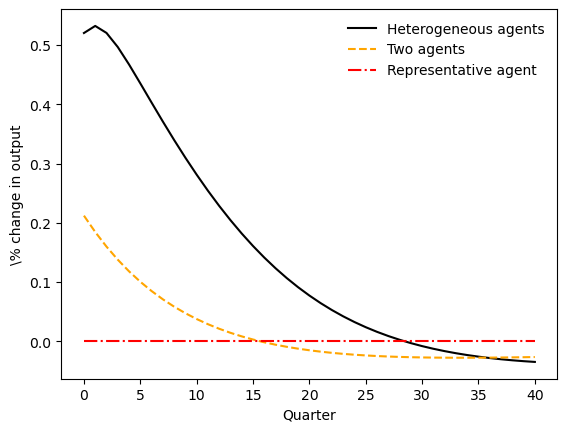

In [34]:
plt.plot(irfs_B['ha'][:41], label='Heterogeneous agents', color='black')
plt.plot(irfs_B['ta'][:41], label='Two agents', linestyle='dashed', color='orange')
plt.plot(irfs_B['ra'][:41], label='Representative agent', linestyle='dashdot', color='red')
plt.legend(frameon=False)
plt.xlabel('Quarter')
plt.ylabel('\% change in output')
plt.savefig('figures/figure2a_deficit_by_model.pdf', bbox_inches='tight')

In [39]:
irfs_CTB = {models['ha'].solve_impulse_linear(ss['ha'], 
                                            unknowns=['Y'], 
                                            targets=['asset_mkt'],
                                            inputs={'B': dB}, 
                                            outputs=['Y','C_T10','C_T50','C_B10','C_B50'],  #change THIS
                                            Js=Js)}

In [40]:
print(irfs_CTB)

{<ImpulseDict: ['Y', 'C_T10', 'C_T50', 'C_B10', 'C_B50']>}


In [42]:
plt.plot(irfs_CTB['C_T10'][:41], label='top 10%', color='black')
plt.plot(irfs_CTB['C_T50'][:41], label='top 50%', linestyle='dashed', color='orange')
plt.plot(irfs_CTB['C_B10'][:41], label='bottom 10%', linestyle='dashdot', color='red')
plt.legend(frameon=False)
plt.xlabel('Quarter')
plt.ylabel('\% change in consumption')
#plt.savefig('figures/figure2a_deficit_by_model.pdf', bbox_inches='tight')

<>:6: SyntaxWarning: invalid escape sequence '\%'
<>:6: SyntaxWarning: invalid escape sequence '\%'
/var/folders/tk/zvlm5zxj4gzfjmrhd2466bv40000gn/T/ipykernel_4773/735637425.py:6: SyntaxWarning: invalid escape sequence '\%'
/var/folders/tk/zvlm5zxj4gzfjmrhd2466bv40000gn/T/ipykernel_4773/735637425.py:6: SyntaxWarning: invalid escape sequence '\%'


TypeError: 'set' object is not subscriptable

In [43]:
variable_names = ['C_T10', 'C_T50', 'C_B10','C_T50']

irfs_CTBk = {k: models['ha'].solve_impulse_linear(ss['ha'], 
                                            unknowns=['Y'], 
                                            targets=['asset_mkt'],
                                            inputs={'B': dB}, 
                                            outputs=['Y'],  #change THIS
                                            Js=Js)[k] for k in variable_names}

KeyError: 'C_T10'

### Figure 2(b)

In [288]:
# EXTENSIONS' model
# tax on the richest 
# re-placing block to fit extension
common_blocks_richest = common_blocks.copy()
common_blocks_richest[2] = fiscal_richest
model_ha_richest = sj.combine(common_blocks_richest + [hh_ha])

irf_B_richest = model_ha_richest.solve_impulse_linear(ss['ha'], unknowns=['Y'], targets=['asset_mkt'],
                                                      inputs={'B': dB}, outputs=['Y'])['Y']

In [289]:
# EXTENSIONS' model
# taylor rule
ss_taylor = ss['ha'].copy()
ss_taylor['phi'], ss_taylor['rstar'] = 1.5, r
model_ha_taylor = sj.combine(common_blocks + [hh_ha, taylor_rule])
irf_B_taylor = model_ha_taylor.solve_impulse_linear(ss_taylor, unknowns=['Y', 'pi'], targets=['asset_mkt', 'nkpc_res'],
                                               inputs={'B': dB}, outputs=['Y'], Js=Js)['Y']

In [290]:
# EXTENSIONS' model
# self financed deficits
irf_B_ALW = models['ha'].solve_impulse_linear(ss['ha'], unknowns=['Y', 'B'], targets=['asset_mkt', 'tax_rate_res'],
                                             inputs={'tax_rate_shock': dT_shock}, outputs=['Y'], Js=Js)['Y']


<>:9: SyntaxWarning: invalid escape sequence '\%'
<>:9: SyntaxWarning: invalid escape sequence '\%'
/var/folders/cr/71dt26rx1ljbqzzzxpwv5g6r0000gn/T/ipykernel_25756/1917097920.py:9: SyntaxWarning: invalid escape sequence '\%'


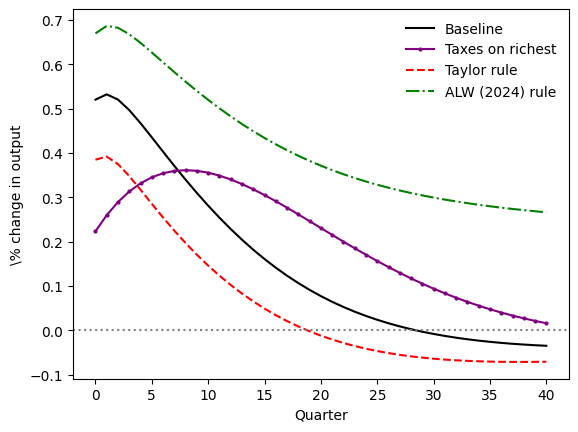

In [291]:
plt.plot(irfs_B['ha'][:41], label='Baseline', color='black')
plt.plot(irf_B_richest[:41], label='Taxes on richest', linestyle='-', color='#800080', marker='o', markersize=2)
plt.plot(irf_B_taylor[:41], label='Taylor rule', linestyle='dashed', color='red')
plt.plot(irf_B_ALW[:41], label='ALW (2024) rule', linestyle='dashdot', color='green')
plt.axhline(y=0, linestyle='dotted', color='gray')

plt.legend(frameon=False)
plt.xlabel('Quarter')
plt.ylabel('\% change in output')
plt.savefig('figures/figure2b_deficit_alternative_rules.pdf', bbox_inches='tight')

# Personal tests

In [292]:
# What we're working with:
print(ss.keys())
# HA
print(ss['ha'].keys())
print(ss['ha'].internals['hh_ha'].keys())
# TA (no internals)
print(ss['ta'].keys())
# RA (no internals)
print(ss['ra'].keys())

dict_keys(['ha', 'ta', 'ra'])
dict_keys(['Y', 'mu', 'r_ante', 'B', 'G', 'tax_rate_shock', 'T_shock', 'T_rule_coeff', 'pi', 'kappa', 'beta_ave', 'vscale', 'frisch', 'eis', 'min_a', 'max_a', 'n_a', 'beta_hi', 'dbeta', 'omega', 'q', 'Tr_lumpsum', 'Tax_richest', 'zeta', 'r_post_bonds', 'qbond', 'N', 'wN', 'div', 'T', 'tax_rate', 'wN_aftertax', 'div_aftertax', 'tax_rate_res', 'T_res', 'constant_owed_res', 'p', 'r_post_equity', 'cap_cond', 'r', 'A', 'C', 'C_T10', 'C_B10', 'C_T50', 'C_B50', 'asset_mkt', 'goods_mkt', 'nkpc_res'])
dict_keys(['e_grid', 'Pi', 'a_grid', 'beta', 'pi_pdf', 'y', 'a', 'c', 'Va', 'Dbeg', 'D', 'c_t10', 'c_b10', 'c_t50', 'c_b50'])
dict_keys(['Y', 'mu', 'r_ante', 'B', 'G', 'tax_rate_shock', 'T_shock', 'T_rule_coeff', 'pi', 'kappa', 'beta_ave', 'vscale', 'frisch', 'eis', 'beta', 'lam', 'C_RA', 'A', 'r_post_bonds', 'qbond', 'N', 'wN', 'div', 'T', 'tax_rate', 'wN_aftertax', 'div_aftertax', 'tax_rate_res', 'T_res', 'constant_owed_res', 'p', 'r_post_equity', 'cap_cond', 'r', '

In [293]:
hh_distribution = ss['ha'].internals['hh_ha']['D']
consumption_distribution = ss['ha'].internals['hh_ha']['c']
ss['ha']['C']

0.8000005881724863

In [294]:
print(irfs_B.keys())

dict_keys(['ha', 'ta', 'ra'])


In [295]:
c_t10, c_b10, c_t50, c_b50 = group_c_not_agg(consumption_distribution, hh_distribution)
print(np.sum(c_t10))
print(np.sum(consumption_distribution))

49878.00398736464
114001.8172257896


In [296]:
print(np.sum(c_t10*hh_distribution))
print(np.sum(consumption_distribution*hh_distribution))

0.264466084753584
0.8000005881724863
